<img src="images/GEMS long.png" width=600 alt="GEMS Logo" title="GEMS" />

# **Spatial Regression**

**Instructors:**  
Yuan Chai (chaix026@umn.edu)  
Ali Joglekar (joglekar@umn.edu)  

---

## Method of Delivery
- Workshop text, images and R code are all contained within a Jupyter Notebook hosted on the GEMS Informatics Platform. You do not need to have R or RStudio installed on your machine to participate
- A recording of the workshop will be posted on Canvas
- Please download any desired materials, as we cannot guarantee access to the Canvas course beyond 3 months.  

---  

## Module Outline: 
- [Raster data in R](#Raster)  
  - [Exercise 1](#Ex1)
- [Raster manipulation](#Manipulation) 
- [Spatial operations](#SpOp)
  - [Exercise 2](#Ex2)
- [Geometry operations](#GeomOp)  
  - [Exercise 3](#Ex3)
- [Raster-Vector interactions](#RasVec)
  - [Exercise 4](#Ex4)

---  


### **Load R Libraries**

In [1]:
# Install and load packages needed for this workshop

packages_to_load <- c("raster", "sf", "spdep", "tmap", "data.table")

for ( package in packages_to_load ) {
    # Check if package is already installed, if not, install and load the package
    if (!require(package, character.only=T, quietly=T, warn.conflicts=F)) {
        install.packages(package)
        suppressPackageStartupMessages(library(package, character.only=T, quietly=T, warn.conflicts=F))
    }
}

# Set plot options
options(repr.plot.width = 8, repr.plot.height = 4)


Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



<details>
    
<summary><span style='color:Green'> Note: For your own work, once packages are installed, it is recommended to just use library() to load your packages  </span></summary>


```
# Spatial data libraries
library(raster)
library(sf)

# Plotting libraries
library(tmap)

# General data analysis libraries
library(data.table)
```
----
          
</details>


### Data

Your expercises will draw on datasets from the Spatial Production Allocation Model (SPAM) and Minnesota Geospatial Commons, which have been downloaded, cleaned, transformed and saved in the directory `./data/MN` for this workshop.

### Attribution

The following material draws heavily from Robin Lovelace's [Geocomputation with R](https://geocompr.robinlovelace.net/index.html) textbook.

<a id="SpDep"></a>
## **Spatial Dependence**

When dealing with space, one must bear in mind Tobler’s first law of geography  

  > **“Everything is related to everything else, but close things are more related than things that are far apart”**  
  > --Tobler (1979)  


**Example**

Tree heights within a region, notice how the tree heights are not randomly distributed across the study area  

<img src="images/tree height.png" width=600 alt="tree" title="Tree Height" />


In this section we’ll focus on the specification of spatial dependence, on specification tests to detect spatial dependence in regressions models and on basic regression models that incorporate spatial dependence.



## **Measuring spatial association and correlation**

An important step in spatial statistics and modelling is to get a measure of the spatial influence between geographic objects.  
This can be expressed as a function of _adjacency_, _closeness_ or _(inverse) distance_, and is often expressed as a spatial weights matrix.  


### **Neighbor Criterion**  
The specification of the neighboring set is quite arbitrary and there’s a wide range of suggestions in the literature. 

In `spdep` package, neighbor relationships between _n_ observations are represented by an `nb` object class  

#### **Contiguity-based neighbors:**  
Neighboring polygons "touch" a focal polygon

<img src="images/neighbor criterion.png" width=600 alt="nb" title="Neighbor Criterion" />


1. **Rook criterion**: neighboring polygons must share a line segment with focal polygon  
2. **Queen criterion**: neighboring polygons must share a vertex with focal polygon  

#### **Distance-based neighbors:**  
Neighboring polygons within a given proximity threshold to a focal polygon  

1. **K-nearest neighbors** retains K nearest neighbors for each focal polygon 
2. **Neighborhood contiguity by distance** retains the neighbors for each focal polygon within a fixed distance band  

**Note:** Distances are measured between polygon centroids.  
If your data are in geographic coordinate system, you can supply the argument `longlat = TRUE` to use great circle distances 

**Example:**  

Reading layer `lux' from data source 
  `/home/u01000040/GEMS Learning/GEMS X003 Spatial Data in R/Module 4 Spatial Regression in R/git/GEMS-Learning-R-Spatial-Regression/data/shp/lux' 
  using driver `ESRI Shapefile'
Simple feature collection with 12 features and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 5.74414 ymin: 49.44781 xmax: 6.528252 ymax: 50.18162
Geodetic CRS:  WGS 84


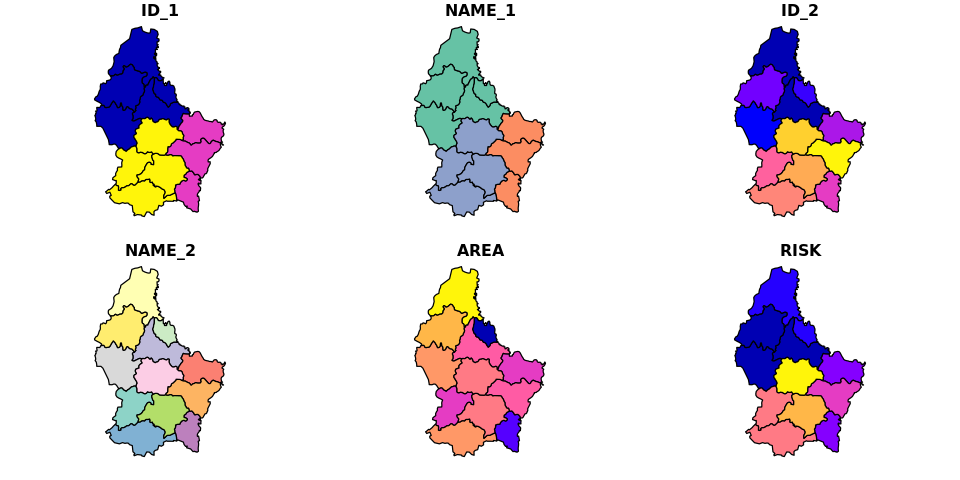

In [62]:
# read in our example shape file
lux <- st_read("./data/shp/lux")
lux <- st_as_sf(lux)
plot(lux)

Neighbour list object:
Number of regions: 12 
Number of nonzero links: 46 
Percentage nonzero weights: 31.94444 
Average number of links: 3.833333 

List of 12
 $ : int [1:3] 2 4 5
 $ : int [1:6] 1 3 4 5 6 12
 $ : int [1:4] 2 5 9 12
 $ : int [1:2] 1 2
 $ : int [1:3] 1 2 3
 $ : int [1:3] 2 8 12
 $ : int [1:3] 8 10 11
 $ : int [1:4] 6 7 11 12
 $ : int [1:4] 3 10 11 12
 $ : int [1:3] 7 9 11
 $ : int [1:5] 7 8 9 10 12
 $ : int [1:6] 2 3 6 8 9 11
 - attr(*, "class")= chr "nb"
 - attr(*, "region.id")= chr [1:12] "1" "2" "3" "4" ...
 - attr(*, "call")= language poly2nb(pl = lux, queen = TRUE)
 - attr(*, "type")= chr "queen"
 - attr(*, "sym")= logi TRUE


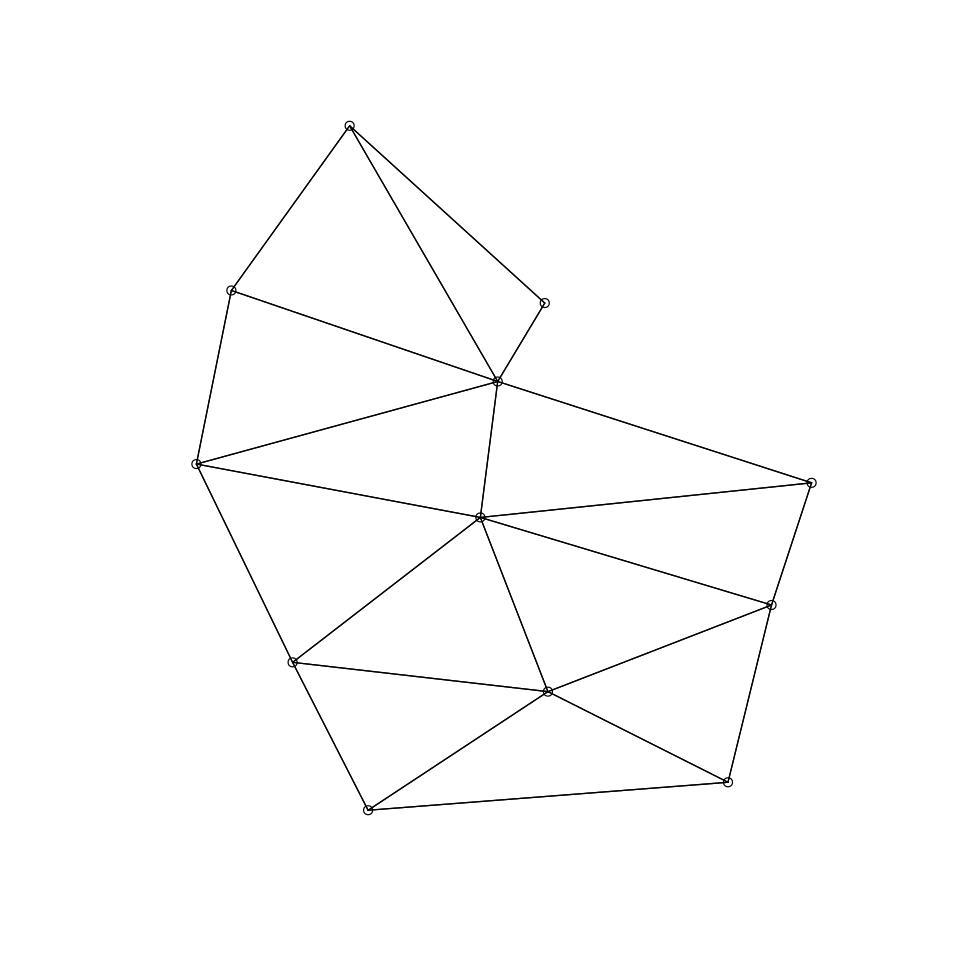

In [96]:
# calculate neighboring using Queen's case (default) 
lux_nbq <- poly2nb(lux, queen=TRUE)
lux_nbq
str(lux_nbq)
plot(lux_nbq, st_coordinates(st_centroid(st_geometry(lux))))

In [68]:
# calculate neighboring using Rook's case
lux_nbr <- poly2nb(lux, queen=FALSE)
lux_nbr

Neighbour list object:
Number of regions: 12 
Number of nonzero links: 46 
Percentage nonzero weights: 31.94444 
Average number of links: 3.833333 

In [71]:
# K-nearest neighbors
lux_nbk <- knn2nb(knearneigh(st_centroid(st_geometry(lux)), k=3))
lux_nbk

Neighbour list object:
Number of regions: 12 
Number of nonzero links: 36 
Percentage nonzero weights: 25 
Average number of links: 3 
Non-symmetric neighbours list

In [97]:
# Neighborhood continuity by distance
lux_nbd <- dnearneigh(st_centroid(st_geometry(lux)), d1 = 0, d2 = 30) # neighbors within 10 km
lux_nbd

Neighbour list object:
Number of regions: 12 
Number of nonzero links: 80 
Percentage nonzero weights: 55.55556 
Average number of links: 6.666667 

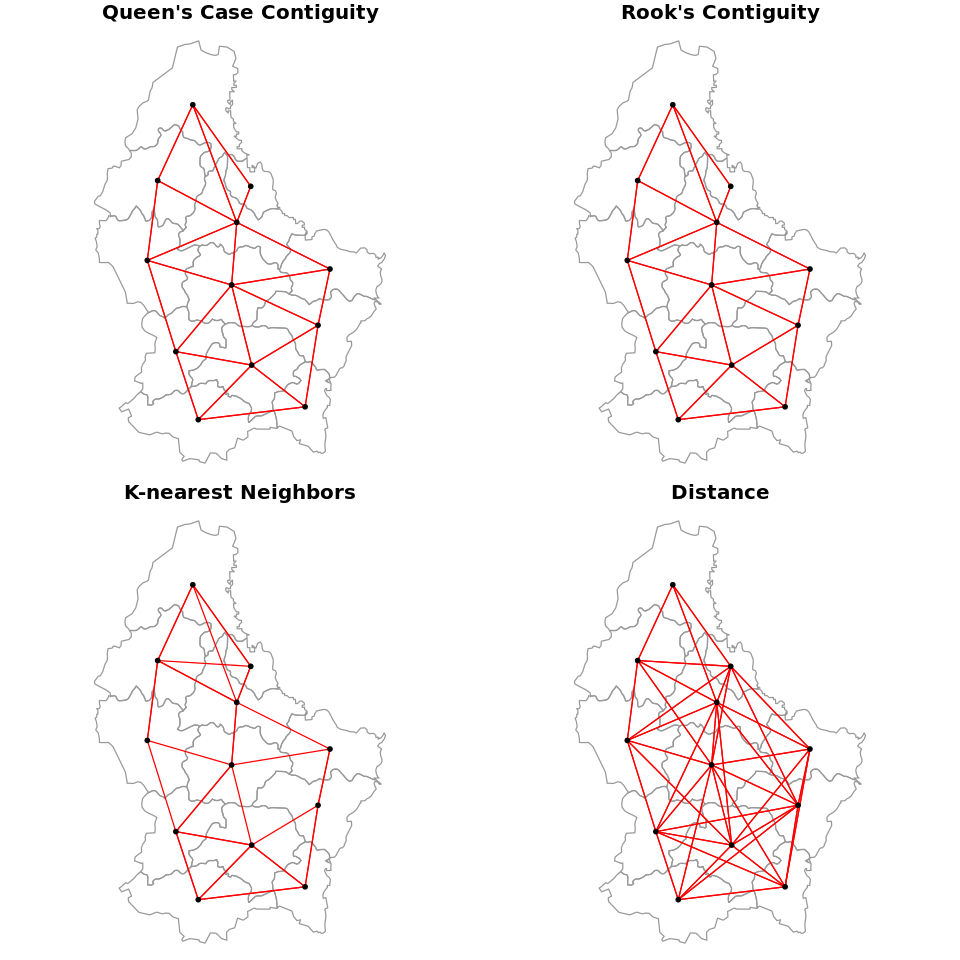

In [91]:
# Plot
options(repr.plot.width = 8, repr.plot.height = 8)

par(mfrow = c(2, 2))
par(mai=c(0,0,0.2,0))

plot(lux$geometry, border = "grey60", main = "Queen's Case Contiguity")
plot(lux_nbq, st_coordinates(st_centroid(st_geometry(lux))), pch = 19, cex = 0.6, col="red", add = TRUE)

plot(lux$geometry, border = "grey60", main = "Rook's Contiguity")
plot(lux_nbr, st_coordinates(st_centroid(st_geometry(lux))), pch = 19, cex = 0.6, col="red", add = TRUE)

plot(lux$geometry, border = "grey60", main = "K-nearest Neighbors")
plot(lux_nbk, st_coordinates(st_centroid(st_geometry(lux))), pch = 19, cex = 0.6, col="red", add = TRUE)

plot(lux$geometry, border = "grey60", main = "Distance")
plot(lux_nbd, st_coordinates(st_centroid(st_geometry(lux))), pch = 19, cex = 0.6, col="red", add = TRUE)


<a id="Ex1"></a>
### **<span style='color:Green'> Exercise 1: Calculating neighbor objects </span>**   

In this exercise, we will first read in a shape file which contains the county boundaries for Minnesota and then create various neighbor objects.  


**Step 1:** Use the `raster()` function to read in raster files from the `'./data/MN/spam/` directory.    

>file `./data/MN/spam/spam_H_MAIZ_A_mn.tif` is the Harvested Area (in hecacres) for Maize in Minnesota  
>file `./data/MN/spam/spam_P_MAIZ_A_mn.tif` is the Production (in metric tons) for Maize in Minnesota  

Use various summarizing functions (e.g., `extent()`, `res()`, `crs()`) to check the two raster files having the same extent and resolution

In [ ]:
# Read in raster files


In [ ]:
# Check for extent, resolution, and crs


<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Read in raster files
spam_H_MAIZ_A_mn <- raster("./data/MN/spam/spam_H_MAIZ_A_mn.tif")
spam_P_MAIZ_A_mn <- raster("./data/MN/spam/spam_P_MAIZ_A_mn.tif")

# Check for extent, resolution, and crs
extent(spam_H_MAIZ_A_mn)
extent(spam_P_MAIZ_A_mn)

res(spam_H_MAIZ_A_mn)
res(spam_P_MAIZ_A_mn)

crs(spam_H_MAIZ_A_mn)
crs(spam_P_MAIZ_A_mn)
```
----
          
</details>

### **Spatial Weight Objects**  
Spatial weights are a list of weights indexed by a list of neighbors.  
Weight of the link between $i$ and $j$ is the $k$th element of the $i$th weights list component  
$k$ tells us which of the $i$th neighbor list component values is equal to $j$  

- Useful to have a formalized way of evaluating spatial relationships
- For a set of *n* units, each observation *i* can be potentially related to all the (*n* - 1) possible units
- In practice we can usually assume that some interactions are more important than others
- Often use a matrix to represent the connectivities between observations

If we know little about the assumed spatial process, we try to avoid moving far from the binary
representation of a weight of unity for neighbors, and zero otherwise.  

In `spdep` package, the `nb2listw` function takes a neighbors list (`nb`) object and converts it into a
weights (`listw`) object.

- For `style="W"` (default), weights vary between 1 divided by the largest and
smallest numbers of neighbors, and the sum of weights for each areal entity
equal 1 (**row standardization**).

- For `style="B"` – ‘binary’ – weights retain unity for each neighbor
relationship, and the sum of weights for areas differ according
to the numbers of neighbor areas have.

Conventionally we always have a 0 in the main diagonal in that each area is not considered a neighbor to itself


**Example:**  Creating Spatial Weight Objects

In [104]:
# Spatial Weight Objects -- Row Standardized
lux_lw_w <- nb2listw(lux_nbq)
summary(lux_lw_w)

Characteristics of weights list object:
Neighbour list object:
Number of regions: 12 
Number of nonzero links: 46 
Percentage nonzero weights: 31.94444 
Average number of links: 3.833333 
Link number distribution:

2 3 4 5 6 
1 5 3 1 2 
1 least connected region:
4 with 2 links
2 most connected regions:
2 12 with 6 links

Weights style: W 
Weights constants summary:
   n  nn S0       S1       S2
W 12 144 12 6.552778 49.74444


In [103]:
# structure of the Spatial Weight Objects
str(lux_lw_w)

List of 3
 $ style     : chr "W"
 $ neighbours:List of 12
  ..$ : int [1:3] 2 4 5
  ..$ : int [1:6] 1 3 4 5 6 12
  ..$ : int [1:4] 2 5 9 12
  ..$ : int [1:2] 1 2
  ..$ : int [1:3] 1 2 3
  ..$ : int [1:3] 2 8 12
  ..$ : int [1:3] 8 10 11
  ..$ : int [1:4] 6 7 11 12
  ..$ : int [1:4] 3 10 11 12
  ..$ : int [1:3] 7 9 11
  ..$ : int [1:5] 7 8 9 10 12
  ..$ : int [1:6] 2 3 6 8 9 11
  ..- attr(*, "class")= chr "nb"
  ..- attr(*, "region.id")= chr [1:12] "1" "2" "3" "4" ...
  ..- attr(*, "call")= language poly2nb(pl = lux, queen = TRUE)
  ..- attr(*, "type")= chr "queen"
  ..- attr(*, "sym")= logi TRUE
 $ weights   :List of 12
  ..$ : num [1:3] 0.333 0.333 0.333
  ..$ : num [1:6] 0.167 0.167 0.167 0.167 0.167 ...
  ..$ : num [1:4] 0.25 0.25 0.25 0.25
  ..$ : num [1:2] 0.5 0.5
  ..$ : num [1:3] 0.333 0.333 0.333
  ..$ : num [1:3] 0.333 0.333 0.333
  ..$ : num [1:3] 0.333 0.333 0.333
  ..$ : num [1:4] 0.25 0.25 0.25 0.25
  ..$ : num [1:4] 0.25 0.25 0.25 0.25
  ..$ : num [1:3] 0.333 0.333 0.333


In [100]:
# Summary of the weights
summary(unlist(lux_lw_w$weights))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1667  0.1750  0.2500  0.2609  0.3333  0.5000 

In [112]:
# Sum of the weights 
sapply(lux_lw_w$weights, sum)

[1] 1 1 1 1 1 1 1 1 1 1 1 1

In [111]:
# A matrix view of the weight assigned
round(listw2mat(lux_lw_w), 2)

1,0.00,0.33,0.00,0.33,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.17,0.00,0.17,0.17,0.17,0.17,0.00,0.00,0.00,0.00,0.00,0.17
3,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.00,0.00,0.25
4,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.33,0.33,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.33
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.33,0.33,0.00
8,0.00,0.00,0.00,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.25,0.25
9,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.25,0.25
10,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.33,0.00,0.33,0.00
11,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.20,0.20,0.20,0.00,0.20


In [105]:
# Spatial Weight Objects -- Binary
lux_lw_b <- nb2listw(lux_nbq, style="B")
summary(lux_lw_b)

Characteristics of weights list object:
Neighbour list object:
Number of regions: 12 
Number of nonzero links: 46 
Percentage nonzero weights: 31.94444 
Average number of links: 3.833333 
Link number distribution:

2 3 4 5 6 
1 5 3 1 2 
1 least connected region:
4 with 2 links
2 most connected regions:
2 12 with 6 links

Weights style: B 
Weights constants summary:
   n  nn S0 S1  S2
B 12 144 46 92 776


In [106]:
# Structure of the spatial weight objects
str(lux_lw_b)

List of 3
 $ style     : chr "B"
 $ neighbours:List of 12
  ..$ : int [1:3] 2 4 5
  ..$ : int [1:6] 1 3 4 5 6 12
  ..$ : int [1:4] 2 5 9 12
  ..$ : int [1:2] 1 2
  ..$ : int [1:3] 1 2 3
  ..$ : int [1:3] 2 8 12
  ..$ : int [1:3] 8 10 11
  ..$ : int [1:4] 6 7 11 12
  ..$ : int [1:4] 3 10 11 12
  ..$ : int [1:3] 7 9 11
  ..$ : int [1:5] 7 8 9 10 12
  ..$ : int [1:6] 2 3 6 8 9 11
  ..- attr(*, "class")= chr "nb"
  ..- attr(*, "region.id")= chr [1:12] "1" "2" "3" "4" ...
  ..- attr(*, "call")= language poly2nb(pl = lux, queen = TRUE)
  ..- attr(*, "type")= chr "queen"
  ..- attr(*, "sym")= logi TRUE
 $ weights   :List of 12
  ..$ : num [1:3] 1 1 1
  ..$ : num [1:6] 1 1 1 1 1 1
  ..$ : num [1:4] 1 1 1 1
  ..$ : num [1:2] 1 1
  ..$ : num [1:3] 1 1 1
  ..$ : num [1:3] 1 1 1
  ..$ : num [1:3] 1 1 1
  ..$ : num [1:4] 1 1 1 1
  ..$ : num [1:4] 1 1 1 1
  ..$ : num [1:3] 1 1 1
  ..$ : num [1:5] 1 1 1 1 1
  ..$ : num [1:6] 1 1 1 1 1 1
  ..- attr(*, "mode")= chr "binary"
  ..- attr(*, "B")= logi TRU

In [107]:
# Summary of the weights
summary(unlist(lux_lw_b$weights))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

In [113]:
# Sum of weights by list
sapply(lux_lw_b$weights, sum)

[1] 3 6 4 2 3 3 3 4 4 3 5 6

In [110]:
# Matrix view of the weights
listw2mat(lux_lw_b)

1,0,1,0,1,1,0,0,0,0,0,0,0
2,1,0,1,1,1,1,0,0,0,0,0,1
3,0,1,0,0,1,0,0,0,1,0,0,1
4,1,1,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,1,0,0,0,1
7,0,0,0,0,0,0,0,1,0,1,1,0
8,0,0,0,0,0,1,1,0,0,0,1,1
9,0,0,1,0,0,0,0,0,0,1,1,1
10,0,0,0,0,0,0,1,0,1,0,1,0
11,0,0,0,0,0,0,1,1,1,1,0,1


<a id="Ex2"></a>
### **<span style='color:Green'> Exercise 2: Calculating neighbor objects </span>**   

In this exercise, we will first read in a shape file which contains the county boundaries for Minnesota and then create various neighbor objects.  


**Step 1:** Use the `raster()` function to read in raster files from the `'./data/MN/spam/` directory.    

>file `./data/MN/spam/spam_H_MAIZ_A_mn.tif` is the Harvested Area (in hecacres) for Maize in Minnesota  
>file `./data/MN/spam/spam_P_MAIZ_A_mn.tif` is the Production (in metric tons) for Maize in Minnesota  

Use various summarizing functions (e.g., `extent()`, `res()`, `crs()`) to check the two raster files having the same extent and resolution

In [ ]:
# Read in raster files


In [ ]:
# Check for extent, resolution, and crs


<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Read in raster files
spam_H_MAIZ_A_mn <- raster("./data/MN/spam/spam_H_MAIZ_A_mn.tif")
spam_P_MAIZ_A_mn <- raster("./data/MN/spam/spam_P_MAIZ_A_mn.tif")

# Check for extent, resolution, and crs
extent(spam_H_MAIZ_A_mn)
extent(spam_P_MAIZ_A_mn)

res(spam_H_MAIZ_A_mn)
res(spam_P_MAIZ_A_mn)

crs(spam_H_MAIZ_A_mn)
crs(spam_P_MAIZ_A_mn)
```
----
          
</details>

### **Spatial autocorrelation**  
- **Positve spatial autocorrelation:** similar values are close to each other
- **Negative spatial autocorrelation:** similar values are distant from each other
- **Random spatial autocorrelation:** similar values are neither close nor distant from each other  

<img src="images/spatial autocorrelation.png" width=800 alt="spauto" title="Spatial Autocorrelation" />

#### Global Indicators of Spatial Association  

**Moran’s I** (`moran.test()`) is perhaps the most common global test. Other global tests implemented in the **spdep** package including Geary’s C (`geary.test()`)


- Measures the linear association between a value and a weighted average of its neighbors
- If there is no spatial clustering in *y*, then the spatial lag of *y* should not vary systematically with *y*

 
**General approach for Moran's I**: standardize observed value by subtracting the analytical expected value, and
dividing the difference by the square root of the analytical variance for the
spatial weights used

$$
I = \frac{n}{\sum_{i=1}^n\sum_{j=1}^n w_{ij}} \frac{\sum_{i=1}^n\sum_{j=1}^n w_{ij} (y_i - \bar y)}{\sum_{i=1}^n (y_i - \bar y)^2}
$$  
where $y_i$ is the $i$th observation, $\bar y$ is the mean of the variable of interest, and
$w_{ij}$ is the spatial weight of the link between $i$ and $j$.

- Result is a standard deviate 
- Compare with normal distribution to find probability value
of observed statistic under the null hypothesis of no spatial dependence
- Most often the test is one-sided, with an alternative
hypothesis of observed statistic being significantly greater than
its expected value
- Outcomes depend on the choices made  


**Moran's I Statistics** 

In [116]:
moran.test(lux$RISK, listw = lux_lw_w)


	Moran I test under randomisation

data:  lux$RISK  
weights: lux_lw_w    

Moran I statistic standard deviate = 2.7529, p-value = 0.002953
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.40426211       -0.09090909        0.03235391 


**Moran's I Plot**  
Global tests for spatial autocorrelation calculated from local relationships
between values observed at a spatial entity and its neighbors, for chosen weights

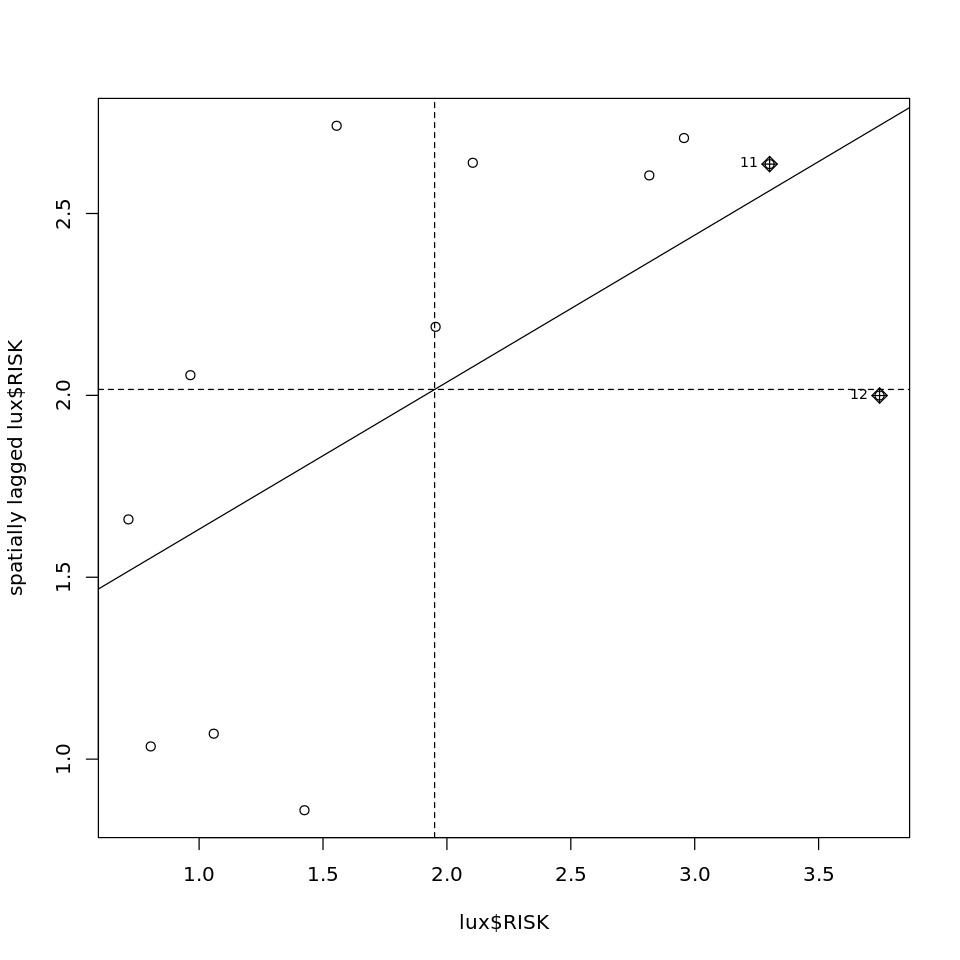

In [117]:
moran.plot(lux$RISK, listw = lux_lw_w)

- Slope coefficient equal to global Moran's I
- Plot is centered on the means

<a id="Ex3"></a>
### **<span style='color:Green'> Exercise 3: Calculating Moran's I </span>**   

In this exercise, we will first read in a shape file which contains the county boundaries for Minnesota and then create various neighbor objects.  


**Step 1:** Use the `raster()` function to read in raster files from the `'./data/MN/spam/` directory.    

>file `./data/MN/spam/spam_H_MAIZ_A_mn.tif` is the Harvested Area (in hecacres) for Maize in Minnesota  
>file `./data/MN/spam/spam_P_MAIZ_A_mn.tif` is the Production (in metric tons) for Maize in Minnesota  

Use various summarizing functions (e.g., `extent()`, `res()`, `crs()`) to check the two raster files having the same extent and resolution

In [ ]:
# Read in raster files


In [ ]:
# Check for extent, resolution, and crs


<details>
    
<summary><span style='color:Green'> Click to see answer  </span></summary>

```
# Read in raster files
spam_H_MAIZ_A_mn <- raster("./data/MN/spam/spam_H_MAIZ_A_mn.tif")
spam_P_MAIZ_A_mn <- raster("./data/MN/spam/spam_P_MAIZ_A_mn.tif")

# Check for extent, resolution, and crs
extent(spam_H_MAIZ_A_mn)
extent(spam_P_MAIZ_A_mn)

res(spam_H_MAIZ_A_mn)
res(spam_P_MAIZ_A_mn)

crs(spam_H_MAIZ_A_mn)
crs(spam_P_MAIZ_A_mn)
```
----
          
</details>

### **Spatial Regression Model**  

OLS assumes that the hypothesis of sphericity of the errors:

\begin{align}
y &= X\beta  +  \varepsilon  \qquad  \\
\end{align}

1. Constant elements on the main diagonal of the variance-covariance
matrix (homoscedasticity)
2. Zero value of the off-diagonal elements of the variance-covariance
matrix (absence of autocorrelation)

\begin{align}
    E(\epsilon \epsilon ') &= \begin{bmatrix}
           \sigma^2 & 0 & \dots & 0\\
           0 & \sigma^2 & \dots & 0\\
           \vdots & \vdots & \vdots & 0\\
           0 & 0 & \dots & \sigma^2
         \end{bmatrix} 
\end{align}

#### **Spatial Regression Models**  
Spatial observations typically have heteroskadastic errors and autocorrelation  
A full generalized spatial regression model with all types of spatial lag effects takes the form:

\begin{equation*}
y = \rho W_1y + X\beta + W_2X\gamma + u  \qquad |\rho| < 1
\label{eq:y} \tag{1}
\end{equation*}


\begin{equation*}
u = \lambda W_3u + \varepsilon \qquad |\lambda| < 1
\label{eq:u} \tag{2}
\end{equation*}

with $X$ a matrix of non-stochastic regressors, $W_i$ a weight matrix
exogenously given, $\beta$ and $\gamma$  are vectors of regression parameters, 
$\varepsilon \sim N(0,\sigma_\varepsilon ^2I_n)$. 

The scalar parameters $\rho$ (spatial autoregressive coefficient) and $\lambda$ 
(spatial autocorrelation coefficient) measure the strength of dependence between units  

The $|\cdot| < 1$ restrictions on $\rho$ and $\lambda$ hold if $W_i$ is row-standardized.

Equation (1) considers endogenous spatial lags among the dependent variable, 
$W_1y$, and the exogenous spatial lags among the independent variables, $W_2X$

Equation (2) considers interaction effects among the the stochastic
disturbance term of different units, $W_3u$

In theory, no need that the three weight matrices are the same, although difficult 
to justify a different choice in practice, $W_i = W$


**Spatial Regression Model Specifications**

1. Spatial Error Model (SEM): $\rho = 0$; $\gamma = 0$; $\lambda \neq 0$
$$
\begin{array}{l}
y = X\beta + u \\
u = \lambda Wu + \varepsilon
\end{array}
$$  

2. Spatial Lag of X Model (SLX): $\rho = 0$ $\gamma \neq 0$ $\lambda = 0$ 
$$
y = X\beta + WX\gamma + \varepsilon
$$  

3. Spatial Lag Model (SLM): $\rho \neq 0$; $\gamma = 0$; $\lambda = 0$  
$$
y = \rho Wy + X\beta + \varepsilon
$$  

4. Spatial Durbin Error Model (SDEM): $\rho = 0$; $\gamma \neq 0$; $\lambda \neq 0$ 
$$
\begin{array}{l}
y = X\beta + WX\gamma + u \\
u = \lambda Wu + \varepsilon
\end{array}
$$  

5. Spatial Durbin Model (SDM): $\rho \neq 0$; $\gamma \neq 0$; $\lambda = 0$
$$
y = \rho Wy + X\beta + WX\gamma + \varepsilon
$$  

6. Spatial Autocorrelation Model (SAC): $\rho \neq 0$ ; $\gamma = 0$; $\lambda \neq 0$
$$
\begin{array}{l}
y = \rho Wy + X\beta + u \\
u = \lambda Wu + \varepsilon
\end{array}
$$  

7. General Nesting Spatial Model (GNS): $\rho \neq 0$; $\gamma \neq 0$; $\lambda \neq 0$  
$$
\begin{array}{l}
y = \rho Wy + X\beta + WX\gamma + u \\
u = \lambda Wu + \varepsilon
\end{array}
$$  

<img src="images/spatial_econometric_models.png" width=800 alt="spmod" title="Spatial Econ Models" />

<a id="Ex5"></a>
### **<span style='color:Green'> At-home Exercise: Learn `terra`  </span>**   

Now that you are familiar with raster data operations in R, it is recommended that you learn `terra` on your own and start use R for raster data analysis for your own work.

Some useful resources to get you started  
>**[The `terra` package](https://rspatial.org/terra/pkg/index.html)**  

>**[A comparison of terra and raster packages](https://www.r-bloggers.com/2021/05/a-comparison-of-terra-and-raster-packages/)**  

>**[Spatial Data Science with R and “terra”](https://rspatial.org/terra/index.html)**

